In [90]:
# importing libraries
import streamlit as st
import datareader as datareader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
from datetime import datetime, timedelta
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from dateutil import parser
from pickle import dump
from pickle import load
from keras.models import load_model
%matplotlib inline

In [91]:
#Loading the data
global coin_name
global start_date
global end_date

In [92]:
coin_list = ['BTC','ETH','HOT1','RSR','NULS','NIM','AION','QASH','VITE','APL','QRL','BCN','GBYTE','LBC','POA','PAC','ILC','BEPRO','GO','XMC']
# coin_name = st.sidebar.selectbox('Select Crypto Currency',coin_list)
# start_date = st.sidebar.date_input('Provide a starting date')
# end_date = st.sidebar.date_input('Provide an ending date')
# currency_list = ['USD','GBP','EUR','INR', 'CAD', 'AUD','JPY','CNY']
# currency = st.sidebar.selectbox('Select a Currency',currency_list)

coin_name = 'BTC'
start_date = '2022-03-01'
end_date = '2022-05-01'
currency = 'USD'

# start_date = start_date.strftime("%Y-%m-%d")
# end_date = end_date.strftime("%Y-%m-%d")
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d').date()                #converting date to date type
end_date = dt.datetime.strptime(end_date, '%Y-%m-%d').date()                    #converting date to date type

In [93]:
crypto_currency = coin_name
against_currency = currency

start = start_date
end = end_date
#start = dt.datetime(2018,1,1)
#end = dt.datetime.now()

#data = web.DataReader(f'{crypto_currency}-{against_currency}','yahoo',start, end)
#data.to_csv('cryptoCoinYahoo.csv')
data = pd.read_csv('cryptoCoinYahoo.csv')
data.set_index('Date', inplace=True)
#prepare data
print(data.shape)
print(data.head())
print(data.info())

(1695, 6)
                    High           Low          Open         Close  \
Date                                                                 
2018-01-01  14112.200195  13154.700195  14112.200195  13657.200195   
2018-01-02  15444.599609  13163.599609  13625.000000  14982.099609   
2018-01-03  15572.799805  14844.500000  14978.200195  15201.000000   
2018-01-04  15739.700195  14522.200195  15270.700195  15599.200195   
2018-01-05  17705.199219  15202.799805  15477.200195  17429.500000   

                 Volume     Adj Close  
Date                                   
2018-01-01  10291200000  13657.200195  
2018-01-02  16846600192  14982.099609  
2018-01-03  16871900160  15201.000000  
2018-01-04  21783199744  15599.200195  
2018-01-05  23840899072  17429.500000  
<class 'pandas.core.frame.DataFrame'>
Index: 1695 entries, 2018-01-01 to 2022-08-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1695 no

In [94]:
data.isnull()
data.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [95]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
#save the scaler
dump(scaler, open('scaler_model1.pkl','wb'))
print(scaled_data)

[[0.16198395]
 [0.18257929]
 [0.18598206]
 ...
 [0.27870792]
 [0.28442936]
 [0.2813506 ]]


In [96]:
global split_percent
split_percent = 0.8
split = int(split_percent*len(scaled_data))
train_scaled = scaled_data[:split]
test_scaled = scaled_data[split:]

global look_back
global future_day
look_back = 60
future_day = 1                                            #   future day prediction = 1st day or 61st prediction from learning 60 days

#creating x_train and y_train from train_scaled

x_train, y_train = [], []

train_scaled1 = scaled_data[:split+future_day]

for x in range(look_back,(len(train_scaled1)-future_day)):                                        # for loop in range (60, 1871)
    x_train.append(train_scaled1[x-look_back:x,0])
    y_train.append(train_scaled1[x:x+future_day, 0])

x_train, y_train = np.array(x_train), np.array(y_train)                             #   x_train : (2352, 60), y_train :   (2352, 1)
print(x_train)


[[0.16198395 0.18257929 0.18598206 ... 0.11641272 0.11131869 0.11991653]
 [0.18257929 0.18598206 0.19217201 ... 0.11131869 0.11991653 0.12202131]
 [0.18598206 0.19217201 0.22062372 ... 0.11991653 0.12202131 0.12829053]
 ...
 [0.4398613  0.44396113 0.42874307 ... 0.66573082 0.64862847 0.68172991]
 [0.44396113 0.42874307 0.41303526 ... 0.64862847 0.68172991 0.69857826]
 [0.42874307 0.41303526 0.44884038 ... 0.68172991 0.69857826 0.69246932]]


In [97]:
print(y_train)

[[0.12202131]
 [0.12829053]
 [0.1286465 ]
 ...
 [0.69857826]
 [0.69246932]
 [0.68445068]]


In [98]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))              #   x_train after reshaping : (2352,60, 1) and converting into 3d array because LSTM receives input in 3D or 3 dimensional array
print(x_train)

[[[0.16198395]
  [0.18257929]
  [0.18598206]
  ...
  [0.11641272]
  [0.11131869]
  [0.11991653]]

 [[0.18257929]
  [0.18598206]
  [0.19217201]
  ...
  [0.11131869]
  [0.11991653]
  [0.12202131]]

 [[0.18598206]
  [0.19217201]
  [0.22062372]
  ...
  [0.11991653]
  [0.12202131]
  [0.12829053]]

 ...

 [[0.4398613 ]
  [0.44396113]
  [0.42874307]
  ...
  [0.66573082]
  [0.64862847]
  [0.68172991]]

 [[0.44396113]
  [0.42874307]
  [0.41303526]
  ...
  [0.64862847]
  [0.68172991]
  [0.69857826]]

 [[0.42874307]
  [0.41303526]
  [0.44884038]
  ...
  [0.68172991]
  [0.69857826]
  [0.69246932]]]


In [99]:
#creating x_test and y_test from test_scaled
test_scaled1 = scaled_data[split-look_back:,:]

x_test = []
y_test = []

for x in range(look_back,len(test_scaled1)-future_day):                         #   (60, 483-6))
    x_test.append(test_scaled1[x-look_back:x,0])
    y_test.append(test_scaled1[x:x+future_day, 0])

x_test, y_test = np.array(x_test), np.array(y_test)                             #   x_train : (483, 60), y_train :   (483,1)
print(x_test)

[[0.41303526 0.44884038 0.45198684 ... 0.69857826 0.69246932 0.68445068]
 [0.44884038 0.45198684 0.47170461 ... 0.69246932 0.68445068 0.70016408]
 [0.45198684 0.47170461 0.48275535 ... 0.68445068 0.70016408 0.68433719]
 ...
 [0.26990141 0.27162782 0.26038008 ... 0.32094681 0.31243923 0.31052318]
 [0.27162782 0.26038008 0.27746148 ... 0.31243923 0.31052318 0.27422311]
 [0.26038008 0.27746148 0.27972759 ... 0.31052318 0.27422311 0.27870792]]


In [100]:
print(y_test)

[[0.70016408]
 [0.68433719]
 [0.61568472]
 [0.58226139]
 [0.62704344]
 [0.64757179]
 [0.61562175]
 [0.61370731]
 [0.62135452]
 [0.60623237]
 [0.58756012]
 [0.59579608]
 [0.63040713]
 [0.6976548 ]
 [0.6913521 ]
 [0.6989452 ]
 [0.71313685]
 [0.75047413]
 [0.81026945]
 [0.78609001]
 [0.78860615]
 [0.80415681]
 [0.8011    ]
 [0.84327641]
 [0.82083386]
 [0.84197544]
 [0.84073847]
 [0.90715261]
 [0.89624372]
 [0.90652565]
 [0.91386998]
 [0.94862688]
 [0.97553256]
 [0.91673168]
 [0.89313609]
 [0.90403848]
 [0.89684462]
 [0.92962849]
 [0.88803004]
 [0.8587839 ]
 [0.89204595]
 [0.91700827]
 [0.91173651]
 [0.9028779 ]
 [0.89798826]
 [0.93252882]
 [0.92854381]
 [0.90494961]
 [0.89987338]
 [0.90611936]
 [0.93409241]
 [1.        ]
 [0.99075083]
 [0.96002495]
 [0.95932124]
 [0.94697834]
 [0.95185298]
 [0.96735604]
 [0.93768144]
 [0.88488148]
 [0.88809562]
 [0.83484097]
 [0.8531441 ]
 [0.87766789]
 [0.86264041]
 [0.82469256]
 [0.84458661]
 [0.82455478]
 [0.84001029]
 [0.78241803]
 [0.8017762 ]
 [0.83

In [101]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))              #   x_test after reshaping : (483, 60, 1)

In [102]:
print(x_test)

[[[0.41303526]
  [0.44884038]
  [0.45198684]
  ...
  [0.69857826]
  [0.69246932]
  [0.68445068]]

 [[0.44884038]
  [0.45198684]
  [0.47170461]
  ...
  [0.69246932]
  [0.68445068]
  [0.70016408]]

 [[0.45198684]
  [0.47170461]
  [0.48275535]
  ...
  [0.68445068]
  [0.70016408]
  [0.68433719]]

 ...

 [[0.26990141]
  [0.27162782]
  [0.26038008]
  ...
  [0.32094681]
  [0.31243923]
  [0.31052318]]

 [[0.27162782]
  [0.26038008]
  [0.27746148]
  ...
  [0.31243923]
  [0.31052318]
  [0.27422311]]

 [[0.26038008]
  [0.27746148]
  [0.27972759]
  ...
  [0.31052318]
  [0.27422311]
  [0.27870792]]]


In [103]:
#Checking shapes
print(type(x_train), type(y_train))                               #   numpy array
print(x_train.shape)
print(y_train.shape)
print(type(x_test), type(y_test))                                 #   numpy array
print(x_test.shape)                                               #   (483, 60, 1)
print(y_test.shape)                                               #   (483,)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1296, 60, 1)
(1296, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(338, 60, 1)
(338, 1)


In [104]:
# Create the model :
# Create Neural Network
model1 = Sequential()
model1.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50))
model1.add(Dropout(0.2))
model1.add(Dense(units=future_day))
model1.summary()

c:\Users\darsh\vscodeProjects\vscdoeProject6Crypto\venvvscdoeProject6Crypto\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
model1.compile(optimizer='adam', loss='mean_squared_error')
model1.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1)                 #keep epochs at least 15
#save the model1                                        # too big model for pickle to save, so use keras.models
#dump(model1, open('model1.pkl','wb'))
model1.save('model1.h5')                                # to save keras model and load the model

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0301 - val_loss: 0.0118
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0021 - val_loss: 0.0156
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0021 - val_loss: 0.0127
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0018 - val_loss: 0.0075
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0018 - val_loss: 0.0124
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0015 - val_loss: 0.0102
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0015 - val_loss: 0.0080
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0015 - val_loss: 0.0127
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0015 - val_loss: 0.0169
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0016 - val_loss: 0.0054


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


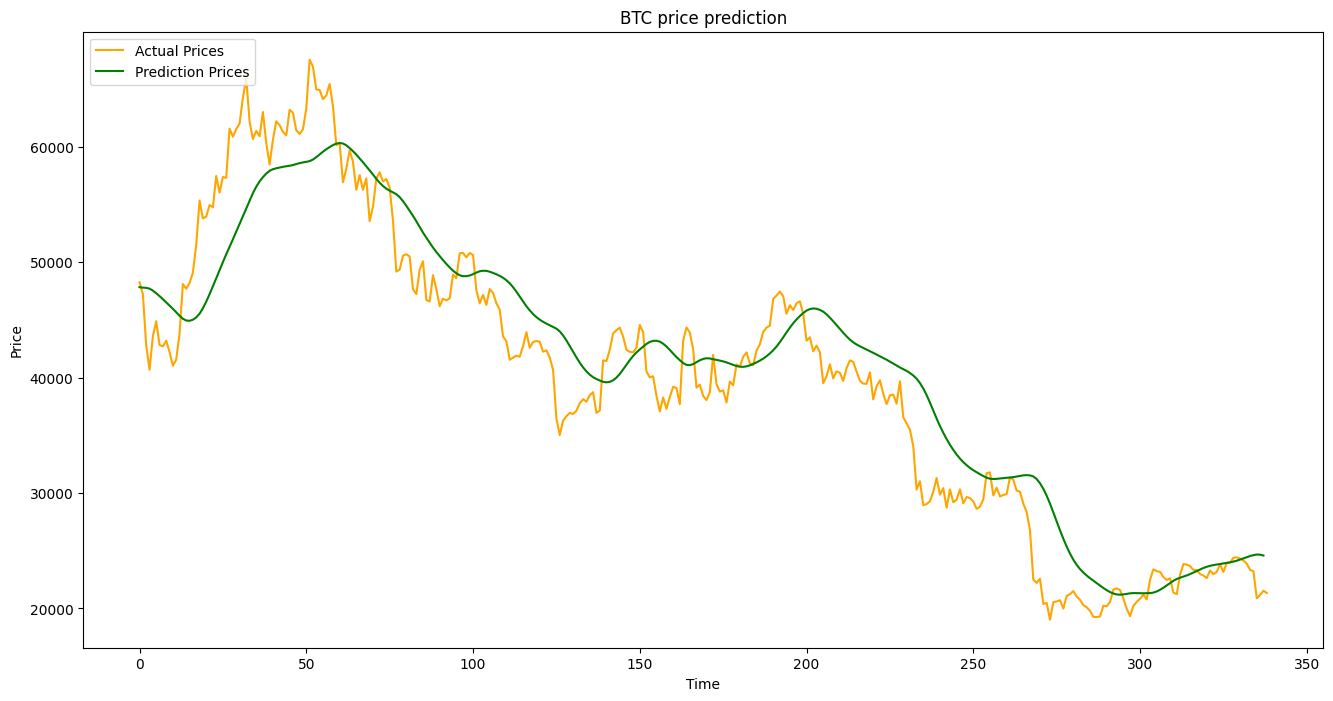

In [106]:
# Evaluate the model on test data
model1.evaluate(x_test, y_test)

# Predict the model on test data and plot the output graph
prediction_prices = model1.predict(x_test, batch_size=1)
prediction_prices = scaler.inverse_transform(prediction_prices)
actual_prices = scaler.inverse_transform(test_scaled)

plt.figure(figsize=(16,8))
plt.plot(actual_prices, color='orange', label='Actual Prices')
plt.plot(prediction_prices, color='green',label='Prediction Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# input_set method to receive the date range and returns X_test,Y_test data set for that specific range
# def input_set(dt0,dt1):

#     dt0 = dt.datetime.strptime(dt0, '%Y-%m-%d').date()
#     dt1 = dt.datetime.strptime(dt1, '%Y-%m-%d').date()
#     delta = abs((dt0 - dt1).days)

#     dt00= dt0 - timedelta(days=look_back)
#     data11 = web.DataReader(f'{crypto_currency}-{against_currency}','yahoo',dt00, dt1)
#     data11.to_csv("coin_SelectedDate.csv")
#     scaler11 = MinMaxScaler(feature_range=(0, 1))
#     scaled_data11 = scaler11.fit_transform(data11['Close'].values.reshape(-1, 1))

In [118]:
#test_scaled11 = scaled_data[-delta:]
def input_set(dt0,dt1):    
    
    dt0 = dt.datetime.strptime(dt0, '%Y-%m-%d').date()
    dt1 = dt.datetime.strptime(dt1, '%Y-%m-%d').date()
    delta = abs((dt0 - dt1).days)

    dt0,dt1,delta

    dt00= dt0 - timedelta(days=look_back)
    #data11 = web.DataReader(f'{crypto_currency}-{against_currency}','yahoo',dt00, dt1)
    #data11.to_csv("coin_SelectedDate.csv")
    data11 = pd.read_csv('coin_SelectedDate.csv')
    scaler11 = MinMaxScaler(feature_range=(0, 1))
    scaled_data11 = scaler11.fit_transform(data11['Close'].values.reshape(-1, 1))

    test_scaled111 = scaled_data11[:,:]

    x_test11 = []
    y_test11 = []

    for x11 in range(look_back,len(test_scaled111)-future_day):                             #   (60, 397))
        x_test11.append(test_scaled111[x11-look_back:x11, 0])
        y_test11.append(test_scaled111[x11:x11+future_day, 0])

    x_test11, y_test11 = np.array(x_test11), np.array(y_test11)                             #   x_train : (483, 60), y_train :   (483,1)
    x_test11 = np.reshape(x_test11, (x_test11.shape[0], x_test11.shape[1], 1))              #   x_test after reshaping : (483, 60, 1)

    print(type(x_test11), type(y_test11))                                #   numpy array
    print(x_test11.shape,y_test11.shape)

    return x_test11,y_test11

# predict method to predict on specific test_set  and plot the chart for actual vs predicted prices + print actual and predicted prices
def predict(x_test1111,y_test1111, start_date, end_date):

    print('Prediction for ' + coin_name + ', for selected date range from ' + start_date + ' to ' + end_date + ' is as following :')
    #st.header('Prediction for ' + coin_name + ' for selected date range from ' + start_date + ' to ' + end_date + ' is as following:')

    model = load_model('model1.h5')                             # to reuse the model
    scaler_model1 = load(open('scaler_model1.pkl','rb'))                                                 # to reuse the scalar

    model.evaluate(x_test1111, y_test1111)
    prediction_test1111= model.predict(x_test1111,batch_size=1)
    prediction_test1111 = scaler_model1.inverse_transform(prediction_test1111)
    actual_prices1111 = scaler_model1.inverse_transform(y_test1111)

#    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d').date()
#    end_date = dt.datetime.strptime(end_date, '%Y-%m-%d').date()
    # print('-----------')
    print(prediction_test1111)
    print(prediction_test1111.shape)
    # print('-----------')
    print(actual_prices1111)
    dates = pd.date_range(start_date, end_date, freq='D')
    print(dates.shape)
    # df1111 = pd.DataFrame({'Date': dates, 'Prediction': prediction_test1111.reshape((-1)), 'Actual':actual_prices1111.reshape((-1))})          # Extremely important way to add dates to dataframe, adding other numpy 1d array thorough ((-1))
    # df1111.set_axis(df1111['Date'], inplace=True)
    # df1111.drop(columns=['Date'], inplace=True)

    # plt.figure(figsize=(16,8))
    # plt.plot(df1111.iloc[:,0], color='orange', label='Prediction Prices')
    # plt.plot(df1111.iloc[:,1], color='green',label='Ground Truth Prices')
    # plt.title(f'{crypto_currency} price prediction', fontsize=24)
    # plt.xlabel('Time', fontsize=24)
    # plt.ylabel(f'Price in {against_currency}', fontsize=24)
    # plt.legend(loc='upper right')
    # plt.show()
    # #st.pyplot(plt)

    # #st.write('Prediction and Actual Prices for ' + coin_name + ' for selected date range from ' + start_date + ' to ' + end_date, df1111)
    # print(df1111)

    return True

## For Final output
# User provide input date range goes here in below method and predict output and plot the graph adn print values too
start_date = str(start_date)
end_date = str(end_date)

a = input_set(start_date,end_date)
predict(a[0],a[1],start_date,end_date)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 60, 1) (10, 1)
Prediction for BTC, for selected date range from 2022-03-01 to 2022-05-01 is as following :
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 0.0013
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[21995.773]
 [22639.824]
 [23183.201]
 [23598.63 ]
 [23938.797]
 [24206.09 ]
 [24426.684]
 [24666.682]
 [24897.604]
 [25169.285]]
(10, 1)
[[23861.46748916]
 [23176.09391561]
 [22053.58414586]
 [25482.06922838]
 [23773.78190241]
 [24891.39934329]
 [28190.93443522]
 [24831.13520902]
 [28910.40174347]
 [28961.88816502]]
(62,)


True

In [ ]:
# ## For Final output
# # User provide input date range goes here in below method and predict output and plot the graph adn print values too
# start_date = str(start_date)
# end_date = str(end_date)

# a = input_set(start_date,end_date)
# predict(a[0],a[1],start_date,end_date)